In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def preprocess_college_data(data):    
    # Creation of binary target based on median graduation rate
    data['grad_success'] = (data['grad_100_value'] > data['grad_100_value'].median()).astype(int) 
    
    categorical_cols = [
        'control', 'level', 'hbcu', 'flagship'
        ] # Singling out categorical columns and convert to a category dtype
    data[categorical_cols] = data[categorical_cols].astype('category')
    
    # Converting expected award value and graduation rate to numeric data, coercing errors to NaN 
    data['exp_award_value'] = pd.to_numeric(data['exp_award_value'], errors='coerce') 
    data['grad_100_value'] = pd.to_numeric(data['grad_100_value'], errors='coerce') 
            
    # Creation of binary features for HBCU and flagship status
    data['hbcu_binary'] = data['hbcu'].apply(lambda x: 1 if x == 'X' else 0) 
    data['flagship_binary'] = data['flagship'].apply(lambda x: 1 if x == 'X' else 0)
    
    # Define the features used for modeling and drop the rest of the columns not in the list
    feature_cols = ['exp_award_value', 'grad_100_value', 'hbcu_binary', 'flagship_binary'] 
    data = data.dropna(subset = feature_cols)
    
    # Creation of a binary target variable based on whether the graduation rate is above or 
    # below the median
    median_grad_100_value = data['grad_100_value'].median() 
    data['target'] = (data['grad_100_value'] >= median_grad_100_value).astype(int)
        
    # Application of Min-Max scaling to the numeric features to bring them to a common scale 
    # between 0 and 1
    normalization = ['exp_award_value', 'grad_100_value'] 
    data[normalization] = MinMaxScaler().fit_transform(data[normalization])
    
    # One-hot encoding of the binary features for HBCU and flagship status, dropping the first 
    # category to avoid multicollinearity
    data_final = pd.get_dummies(data[feature_cols + ['target']], drop_first=True)

    # Visualization of the distribution of the normalized numeric features to be used in the 
    # visualize_and_split function to create a density plot
    return data_final, normalization, (2,2), 'target'


def preprocess_placement_data(data):
    # Conversion of categorical columns to category dtype and numeric columns to float dtype
    categorical_cols = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation']
    data[categorical_cols] = data[categorical_cols].astype('category')
    numeric_cols = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']        
    data[numeric_cols] = data[numeric_cols].astype(float)
    
    # Grouping the most common degree types into a single category and labeling the rest as 
    # 'Other' to reduce the number of categories in the degree_t column
    top_degrees = ['Comm&Mgmt', 'Sci&Tech']
    data['degree_t'] = data['degree_t'].apply(lambda x: x if x in top_degrees else 'Other').astype('category')
    
    # One-hot encoding of the categorical variables, dropping the first category, and scaling
    # the numeric features using Min-Max scaling to bring them to a common scale between 0 and 1
    encode_cols = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
    data_1hot = pd.get_dummies(data, columns = encode_cols, drop_first = True)
    scaler = MinMaxScaler()
    data_1hot[numeric_cols] = scaler.fit_transform(data_1hot[numeric_cols])
        
    # Creation of the final dataset for modeling by dropping unnecessary columns and creating a
    # binary target variable based on the placement status
    data_final = data_1hot.drop(['sl_no', 'salary'], axis = 1, errors ='ignore')
    data_final['target'] = (data_final['status'] == 'Placed').astype(int)
    data_final = data_final.drop('status', axis = 1)
    
    # Visualization of the distribution of the normalized numeric features to be used in the 
    # visualize_and_split function to create a density plot
    return data_final, numeric_cols, (3, 2), 'target'

def visualize_and_split(data_final, plot_cols, plot_layout, target_col):
    # Visualization of the distribution of the numeric features using density plots
    data_final[plot_cols].plot.density(subplots = True, layout = plot_layout, figsize = (10, 8))
    plt.tight_layout()
    plt.show()

    # Calculating the prevalence of the target variable of the dataset in question
    prevalence = data_final['target'].mean()
    print(f"Prevalence of target variable: {prevalence:.2%}")

    # Splitting the dataset into training, tuning, and testing sets with stratification based 
    # on the target variable to maintain class distribution
    train, test = train_test_split(data_final, train_size = 0.2, stratify = data_final[target_col], RANDOM_STATE = 42)
    tune, test = train_test_split(test, test_size = 0.5, stratify = test[target_col], RANDOM_STATE = 42)
    
    # Returning the training, tuning, and testing sets in additon to the target variable prevalence
    return train, tune, test, prevalence

def preprocess_data_main(url):
    # Reading the dataset from the provided URL
    raw = pd.read_csv(url)

    # This loop sorts the inputted URL to determine which preprocessing function to call
    if "cc_institution_details" in url:
        data_final, plot_cols, plot_layout, target_col = preprocess_college_data(raw)

    elif "Placement_Data" in url or "placement_data" in url.lower():
        data_final, plot_cols, plot_layout, target_col = preprocess_placement_data(raw)

    else:
        print("Unknown dataset. Please provide a valid URL for either college or placement data.")
        return None, None, None, None
    
    # Calls the visualize_and_split function on the newly processed data
    return visualize_and_split(data_final, plot_cols, plot_layout, target_col)
    

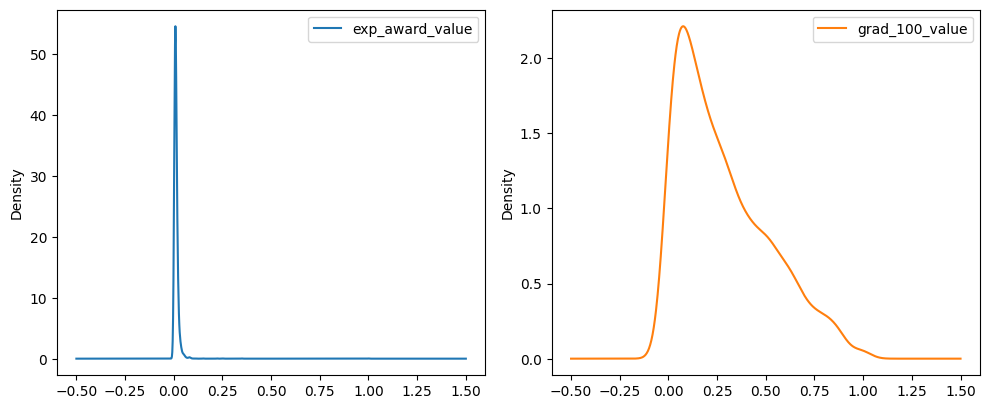

Prevalence of target variable: 50.10%


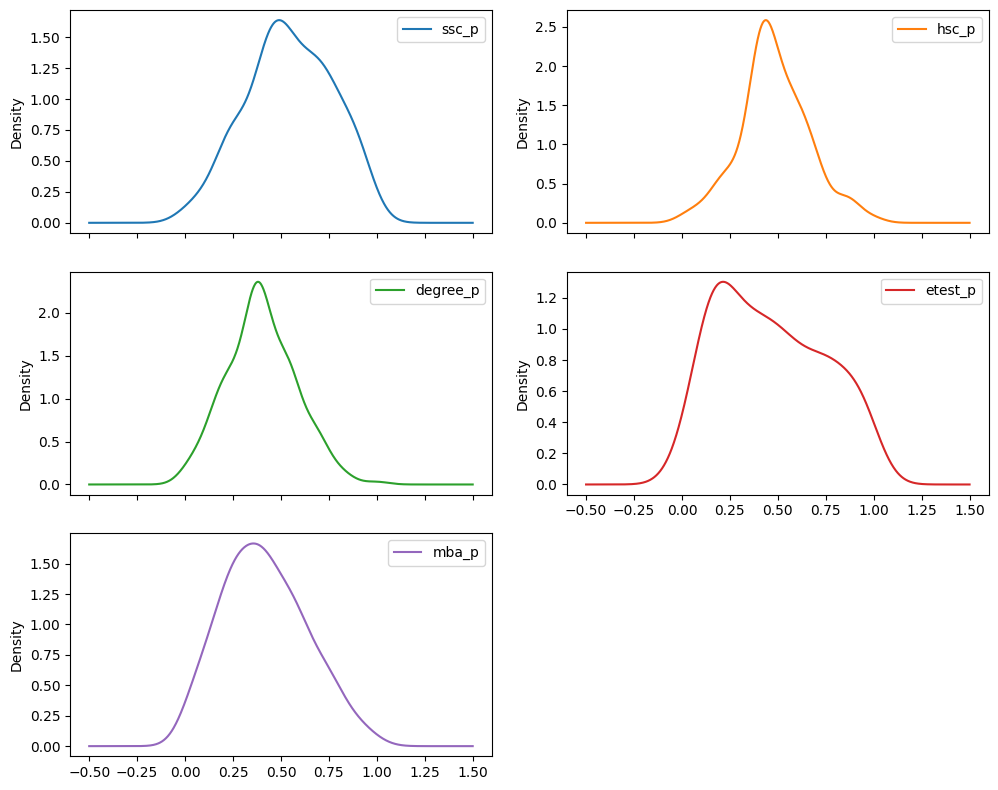

Prevalence of target variable: 68.84%


In [ ]:
# Tester data to ensure all of the functions work
Train_c, Tune_c, Test_c, prevalence_c = preprocess_data_main('../data/cc_institution_details.csv')
Train_p, Tune_p, Test_p, prevalence_p = preprocess_data_main('../data/Placement_Data_Full_Class.csv')